In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
import tensorflow as tf
import numpy as np
import os
import pandas as pd #資料處理
import torch
import matplotlib.pyplot as plt
from PIL import Image

# 設定dataset路徑
project_path = r"D:\NTUT\Weather_AI\self-project\GAN\weather-GAN"
train_data_path = str(project_path + r"\train_data")
output_data_path = str(project_path + r"output_data")


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11395340718627821256
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5748293632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1969875704909194924
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [5]:
# Setup GPU
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
for gpu in gpus :
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
class My_Dataset(Dataset) :
    def __init__(self, path, transform=None) :
        super().__init__()
        self.image_files = os.listdir(path)
        self.list_files = []
        for file in self.image_files :
            self.list_files.append(os.path.join(path, file))

    # Indicate the total size of the dataset
    def __len__(self) :
        return len(self.image_files)
    
    # 1. Read from file (using numpy.fromfile, PIL.Image.open)
    # 2. Preprocess the data (torchvision.Transform).
    # 3. Return the data (e.g. image and label)
    def __getitem__(self, index) :
        image = Image.open(self.list_files[index]).convert('RGB')
        if transform is None :
            return image
        else :
            image = transform(image)
            return image

#讀取圖片，一次四張
if __name__ == '__main__' :
    #path_image = r"D:\NTUT\Weather_AI\self-project\GAN\weather-GAN\train_data"
    path_image = train_data_path
    train_data = My_Dataset(path_image, transform=transform)
    train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True)
    for image in train_dataloader :
        print(image.shape)
        #4(張), 3(RGB三通道), 3600(長), 3600(寬)縮成256*256
        break

torch.Size([10, 3, 64, 64])


In [9]:
# 切割資料集
from sklearn.model_selection import train_test_split

train, test = train_test_split(image, test_size = 0.2, random_state = 42)

In [10]:
train = np.array(train)
test = np.array(test)

train.shape, test.shape

((8, 3, 64, 64), (2, 3, 64, 64))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


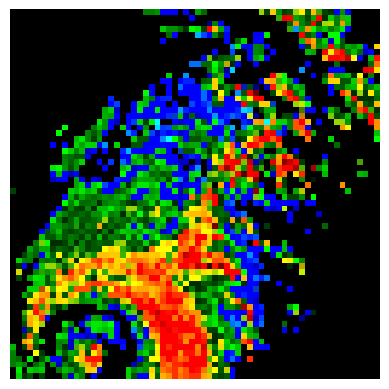

In [11]:

plt.imshow(np.transpose(test[0], (1, 2, 0)))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


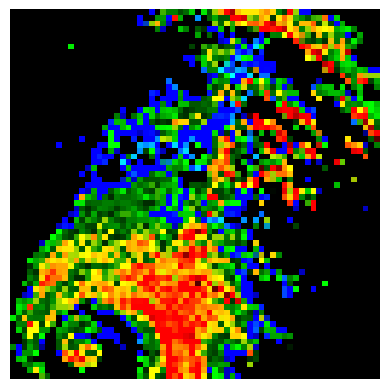

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


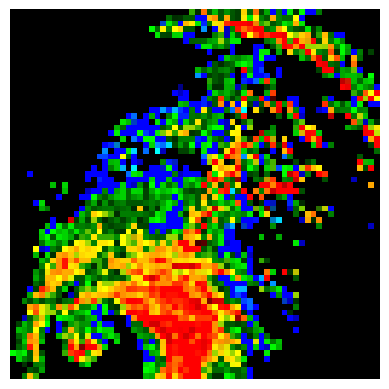

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


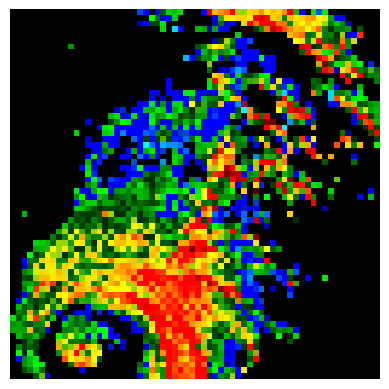

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


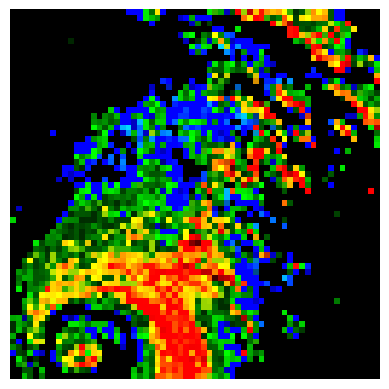

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


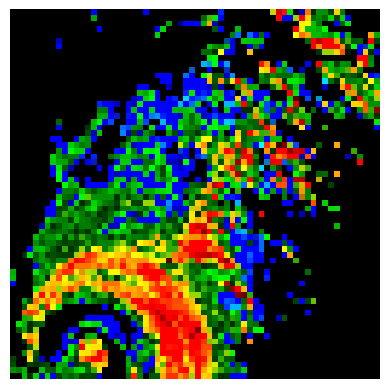

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


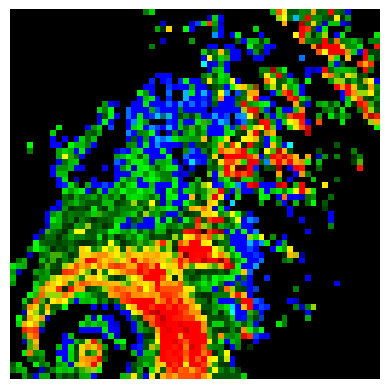

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


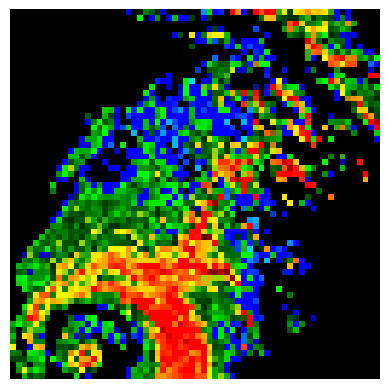

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


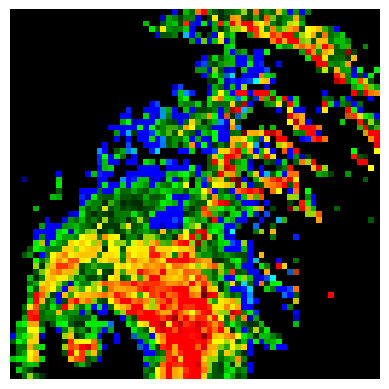

In [12]:
for i in range(len(train)) :
    plt.imshow(np.transpose(train[i], (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [13]:
print(train)

[[[[-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   ...
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]]

  [[-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   ...
   [-1.         -1.          0.4876225  ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]]

  [[-1.         -1.         -1.         ... -1.         -1

In [14]:
# 把所有圖片建立成一個Dataset--weather_dataset
weather_dataset = tf.data.Dataset.list_files("train_data/*.jpg")
# weather_dataset = np.array(weather_dataset)
# weather_dataset.shape
data_iterator = weather_dataset.as_numpy_iterator()
data_iterator.next()

b'train_data\\837.jpg'

Build Nerual Network

In [15]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the NN
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D


Build generator

In [16]:
def build_generator() :
    model = Sequential()

    # Beginnings of a generated image
    model.add(Dense(8*8*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8, 8, 128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 3
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # # Upsampling block 4
    # model.add(UpSampling2D())
    # model.add(Conv2D(128, 5, padding = 'same'))
    # model.add(LeakyReLU(0.2))

    # # Upsampling block 5
    # model.add(UpSampling2D())
    # model.add(Conv2D(128, 5, padding = 'same'))
    # model.add(LeakyReLU(0.2))

    # Convolution block 1
    model.add(Conv2D(128, 4, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Convolution block 2
    model.add(Conv2D(128, 4, padding = 'same'))
    model.add(LeakyReLU(0.2))

    #Conv layer to get to three channel, because R,G,B
    model.add(Conv2D(3, 4, padding = 'same', activation = 'sigmoid'))

    return model

In [17]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                        

In [18]:
img = generator.predict(np.random.randn(4, 128))
img

1/1 [==============================] - 4s 4s/step


array([[[[0.5046213 , 0.501214  , 0.49368125],
         [0.50738233, 0.50062174, 0.49452257],
         [0.5108559 , 0.5055995 , 0.4952845 ],
         ...,
         [0.50577706, 0.5041008 , 0.50336677],
         [0.5070772 , 0.50258565, 0.5027028 ],
         [0.50442094, 0.50015384, 0.5030067 ]],

        [[0.50468034, 0.50046164, 0.4940913 ],
         [0.50668377, 0.49594146, 0.4934772 ],
         [0.5055417 , 0.50086147, 0.4948278 ],
         ...,
         [0.5022819 , 0.5021623 , 0.50110376],
         [0.50456434, 0.50209254, 0.5015728 ],
         [0.5039874 , 0.49875358, 0.5034525 ]],

        [[0.5039023 , 0.5046405 , 0.49290267],
         [0.5042382 , 0.49777624, 0.4896163 ],
         [0.50036865, 0.5007762 , 0.492722  ],
         ...,
         [0.5032239 , 0.50270903, 0.50338686],
         [0.50559217, 0.50276124, 0.50224817],
         [0.5043171 , 0.49876708, 0.50480014]],

        ...,

        [[0.5099585 , 0.501906  , 0.49977252],
         [0.506615  , 0.50345856, 0.5002763 ]

In [19]:
img.shape

(4, 64, 64, 3)

In [20]:
len(img)

4

In [21]:
# for i in range(len(img)) :
#     plt.imshow(img[i])
#     plt.axis('off')
#     plt.show()

Build Discriminator

In [22]:
img.shape

(4, 64, 64, 3)

In [23]:
def build_discriminator() :
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (64, 64, 3)))
    model.add(LeakyReLU(0.2))
    # Dropout可以降低discriminator訓練的速度
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # # Fifth Conv Block
    # model.add(Conv2D(256, 5))
    # model.add(LeakyReLU(0.2))
    # model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))


    return model

In [24]:
img.shape

(4, 64, 64, 3)

In [25]:
discriminator = build_discriminator()

In [26]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 60, 60, 32)        0         
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        51264     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 56, 56, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)      

In [27]:
discriminator.predict(img)

1/1 [==============================] - 0s 87ms/step


array([[0.49867707],
       [0.49890175],
       [0.498848  ],
       [0.49874574]], dtype=float32)

Training Loop

Setup Losses and Optimizers

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [29]:
# determine g & d's optimizer
generator_opt = Adam(learning_rate=0.0001)
discirminator_opt = Adam(learning_rate=0.00001)
# determine g & d's losses
generator_loss = BinaryCrossentropy()
discriminator_loss = BinaryCrossentropy()

Build Subclassed Model

In [30]:
# improting the base model class to subclass our training step
from tensorflow.keras.models import Model

In [31]:
class WeatherGAN(Model) : 
    # *args = any positional arg, **kwargs = keyboard args, those two parameters are make our function flexible
    def __init__(self, generator, discriminator, *args, **kwargs) :
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attribute for gen and dis
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, generator_opt, discirminator_opt, generator_loss, discriminator_loss, *args, **kwargs) :
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for optimizer and losses
        self.generator_opt = generator_opt
        self.discriminator_opt = discirminator_opt
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

    def train_step(self, batch) :
        # Get the data
        real_images = batch
        # Use generator to prediction fake image
        fake_images = self.generator(tf.random.normal((128, 128)), training = False)

        # Train the discriminator
        with tf.GradientTape() as d_tape :
            # Pass the real and fake images to the discriminator model
            real_images = tf.transpose(real_images, perm=[0, 3, 2, 1]) # Change the dimension to (None, 3, 256, 256)
            yhat_real = self.discriminator(real_images, training = True)
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_real_fake = tf.concat([yhat_real, yhat_fake], axis = 0) # Predictions(label) from discriminator

            # Create labels for the real and fake image
            y_real_fake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis = 0) # Actual label, real image label = 0, fake image label = 1

            # Add some noise to the TRUE outputs
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real)) # Uniform distribution
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_real_fake += tf.concat([noise_real, noise_fake], axis = 0)

            # Calculate loss - BinaryCorss
            total_d_loss = self.discriminator_loss(y_real_fake, yhat_real_fake)

        # Apply backpropagation, nn learn. trainable_variables = the variable we want to calculate the gradients
        d_gradients = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) # Calculate gradient
        self.discriminator_opt.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables)) # Apply gradients using optimizer

        # Train the generator
        with tf.GradientTape() as g_tape :
            # Generator some nwe images
            gene_images = self.generator(tf.random.normal((128, 128)), training = True)

            # Create the predicted labels, running our gene_images through the discriminator
            predicted_labels = self.discriminator(gene_images, training = False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backpropagation
        g_gradients = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.generator_opt.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"discriminator_loss":total_d_loss, "generator_loss":total_g_loss}
    # test & evaluation something
    def test_step(self) :
            pass
    

In [32]:
# Create instance of subclass model
weatherGan = WeatherGAN(generator, discriminator)

In [33]:
# Compile the model
weatherGan.compile(generator_opt, discirminator_opt, generator_loss, discriminator_loss)

Build Callback

In [34]:
# import os -> helps with folder navigation (import previously)
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback # Create out own custom callback on epoch

In [35]:
class ModelMonitor(Callback) :
    def __init__(self, num_img = 3, latent_dim = 128) : # latent_dim -> the random value that i passing to generator to generator a random image, num_img -> how much need to generate
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs = None) :
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim))
        generated_img = self.model.generator(random_latent_vectors)
        generated_img *= 255
        generated_img.numpy()
        for i in range(self.num_img) :
            img = array_to_img(generated_img[i])
            img.save(os.path.join('generated_images_64_64', f'generated_img_{epoch}_{i}.png'))


Train

In [36]:
train

array([[[[-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         ...,
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ]],

        [[-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         ...,
         [-1.        , -1.        

In [37]:
train.shape

(8, 3, 64, 64)

In [38]:
# Recommend 2000 epochs
#hist = weatherGan.fit(train, batch_size=8, epochs=20)
hist = weatherGan.fit(train, batch_size=1, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10


8/8 [==============================] - 1873s 18s/step - discriminator_loss: 0.5711 - generator_loss: 0.8356
Epoch 2/10
8/8 [==============================] - 139s 17s/step - discriminator_loss: 0.6963 - generator_loss: 0.7057
Epoch 3/10
8/8 [==============================] - 145s 18s/step - discriminator_loss: 0.7054 - generator_loss: 0.7038
Epoch 4/10
8/8 [==============================] - 157s 20s/step - discriminator_loss: 0.6978 - generator_loss: 0.7100
Epoch 5/10
8/8 [==============================] - 159s 19s/step - discriminator_loss: 0.6895 - generator_loss: 0.7162
Epoch 6/10
8/8 [==============================] - 154s 19s/step - discriminator_loss: 0.6809 - generator_loss: 0.7228
Epoch 7/10
8/8 [==============================] - 153s 19s/step - discriminator_loss: 0.6714 - generator_loss: 0.7303
Epoch 8/10
8/8 [==============================] - 147s 18s/step - discriminator_loss: 0.6611 - generator_loss: 0.7401
Epoch 9/10
8/8 [==============================] - 141s 18s/step - 